# Projeto 12: Validação Cruzada - Rede Neural Convolucional MNIST

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0 skorch==0.7.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import optim
from torchvision import datasets
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Etapa 2: Base de dados

In [3]:
torch.manual_seed(123)

In [4]:
transform = transforms.ToTensor()

In [5]:
X = datasets.MNIST(root = '.', train=True, download=True, transform=transform)
#y = datasets.MNIST(root = '.', train=False, download=True, transform=transform)

In [6]:
X.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
X.data.shape

torch.Size([60000, 28, 28])

In [8]:
X.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
train_loader = torch.utils.data.DataLoader(X, batch_size=128)
#test_loader = torch.utils.data.DataLoader(y, batch_size=128)

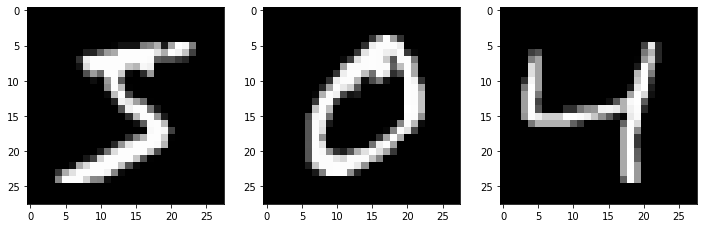

In [10]:
_, ax = plt.subplots(1,3, figsize=(12,5))
for i in range(3):
  img = next(iter(train_loader))[0][i].view(28,28)
  ax[i].imshow(img, cmap='gray')
plt.show()

In [11]:
img.shape

torch.Size([28, 28])

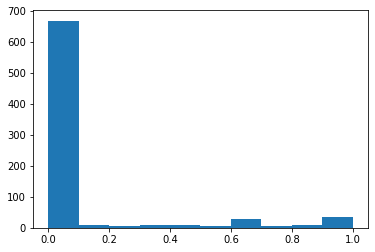

In [12]:
plt.hist(img.view(-1));

## Etapa 3: Construção do modelo

In [13]:
class cls_torch(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32,32,(3,3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.flatten = nn.Flatten()
    
    # output = (input - filter + 1) / stride
    # Convolução 1: (28 - 3 + 1) / 1 = 26 => img(26px X 26px)
    # Pooling 1: kernel_size=(2,2) => 26 / 2, 26 / 2 => img(13px X 13px)
    # Convolução 2: (13 - 3 + 1) / 1 = 11 => img(11px X 11px)
    # Pooling 2: kernel_size=(2,2) => 11 / 2, 11 / 2 => img(5px X 5px)
    # Saída Pooling 2 = 5 * 5 * 32 (BatchNorm2d(num_features=32))
    # 800 -> 128

    self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = X.view(-1, 1, 28, 28) ##### Tem que transformar as imagens no formato que as CNNs operam no PyTorch: (batch_size, n_dimensions, width, height)     
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)
    return X

In [21]:
cls_sklearn = NeuralNetClassifier(module = cls_torch,
                                  criterion = torch.nn.CrossEntropyLoss,
                                  optimizer = torch.optim.Adam,
                                  max_epochs = 10,
                                  batch_size = 60,
                                  train_split = False)

## Etapa 4: Validação Cruzada

In [22]:
train = X.data.type('torch.FloatTensor')
targets = X.targets.type('torch.LongTensor')

In [23]:
results = cross_val_score(cls_sklearn, train, targets, cv = 10, scoring = 'accuracy')

  epoch    train_loss      dur
-------  ------------  -------
      1        0.2891  42.8995
      2        0.1448  41.8783
      3        0.1368  41.3103
      4        0.1238  41.1412
      5        0.1313  41.2187
      6        0.1147  41.2849
      7        0.1428  41.4553
      8        0.1075  42.1953
      9        0.1295  42.7304
     10        0.1186  42.1332
  epoch    train_loss      dur
-------  ------------  -------
      1        0.2283  41.4811
      2        0.1212  41.0239
      3        0.1128  41.1575
      4        0.1190  40.4598
      5        0.1106  40.8031
      6        0.1222  41.0150
      7        0.1063  41.0389
      8        0.1076  41.0696
      9        0.1039  41.3029
     10        0.1176  40.8075
  epoch    train_loss      dur
-------  ------------  -------
      1        0.2333  40.2620
      2        0.1229  40.3642
      3        0.1220  40.4981
      4        0.1046  40.7003
      5        0.1105  40.5046
      6        0.1052  40.4423
      7 

In [24]:
mean = results.mean()
std = results.std()
mean, std

(0.6716166666666666, 0.13109225017351545)

In [25]:
results

array([0.86583333, 0.7275    , 0.593     , 0.788     , 0.561     ,
       0.67466667, 0.3925    , 0.7345    , 0.59866667, 0.7805    ])